In [1]:
# Import packages
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, display_rgb, SEG_CMAP
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

import unagi

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, vstack
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.convolution import convolve, Gaussian2DKernel

In [4]:
from kuaizi.fit import ScarletFitter, fitting_obs_tigress

In [5]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.utils.set_matplotlib(style='default', usetex=False)

In [6]:
lsbg_cat = Table.read('/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Catalog/NSA/z001_002/nsa_cutout_cat_z001_002.fits')
print('# of LSBGs:', len(lsbg_cat))

# of LSBGs: 2791


In [78]:
lsbg = lsbg_cat[lsbg_cat['viz-id'] == 67037][0]

In [ ]:
prefix = 'LSBG'
channels = 'griz'
index = lsbg['viz-id']

bright = (lsbg['mag_auto_i'] < 17.5)
print('Bright =', bright)

lsbg_coord = SkyCoord(ra=lsbg['ra'], dec=lsbg['dec'], unit='deg')
cutout = [fits.open(f"{lsbg['prefix']}_{band}.fits") for band in channels]
psf_list = [fits.open(f"{lsbg['prefix']}_{band}_psf.fits") for band in channels]

images = np.array([hdu[1].data for hdu in cutout])
# note: all bands share the same WCS here, but not necessarily true.
w = wcs.WCS(cutout[0][1].header)
weights = 1.0 / np.array([hdu[3].data for hdu in cutout])
weights[np.isinf(weights)] = 0.0
psf_pad = padding_PSF(psf_list)  # Padding PSF cutouts from HSC
psfs = scarlet.ImagePSF(np.array(psf_pad))
# saturation mask and interpolation mask from HSC S18A
sat_mask = np.array([sum(unagi.mask.Mask(
    hdu[2].data, data_release='s18a').extract(['INTRP', 'SAT'])) for hdu in cutout])
data = Data(images=images, weights=weights, masks=sat_mask,
            wcs=w, psfs=psfs, channels=channels)

### Running scarlet spergel modeling for `/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/z001_002/nsa_70832`
    Working directory: /scratch/gpfs/jiaxuanl/Data/HSC/LSBG
  - Detect sources and make mask
    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    8 stars from Gaia are masked!
    Detected 268 objects
    7 stars from Gaia are masked!
    Detected 183 objects
    Detected 113 objects


Traceback (most recent call last):
  File "/home/jiaxuanl/Research/Packages/kuaizi/kuaizi/fit.py", line 1109, in fit
    self._add_other_sources(min_grad=self.min_grad, thresh=0.1)
  File "/home/jiaxuanl/Research/Packages/kuaizi/kuaizi/fit.py", line 751, in _add_other_sources
    tempid, sep2d, _ = match_coordinates_sky(big, star)
UnboundLocalError: local variable 'big' referenced before assignment
Traceback (most recent call last):
  File "/home/jiaxuanl/Research/Packages/kuaizi/kuaizi/fit.py", line 1109, in fit
    self._add_other_sources(min_grad=self.min_grad, thresh=0.1)
  File "/home/jiaxuanl/Research/Packages/kuaizi/kuaizi/fit.py", line 751, in _add_other_sources
    tempid, sep2d, _ = match_coordinates_sky(big, star)
UnboundLocalError: local variable 'big' referenced before assignment

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jiaxuanl/Research/Packages/kuaizi/kuaizi/fit.py", line 1282, in fitting_obs_t

  - Added Spergel profile with bbox = (4, 150, 150)
None


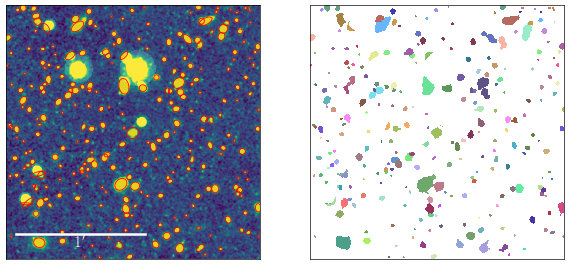

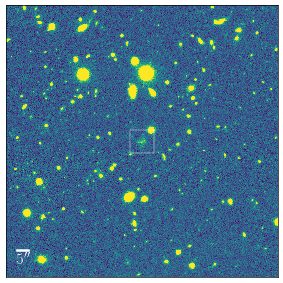

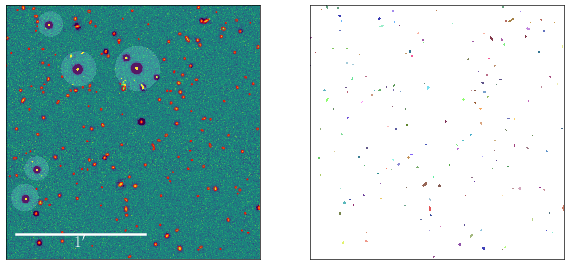

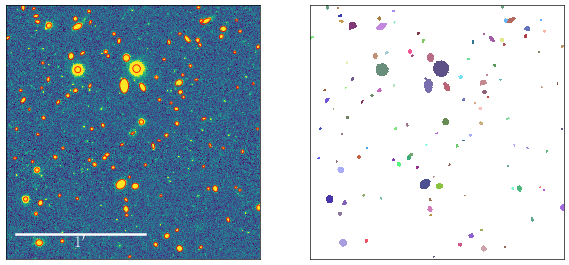

In [140]:
fitting_obs_tigress(env_dict, 
                    lsbg, 
                    name='viz-id',
                    method='spergel', 
                    min_grad=-0.1,
#                     starlet_thresh=0.3,
#                     monotonic=True,
                    bkg=True,
#                     variance=0.015**2,
#                     scales=[0, 1, 2, 3, 4],
                    prefix='nsa', 
                    log_dir='./log/nsa_z001_002/', 
                    figure_dir='./Figure/nsa_z001_002/',
                    model_dir='./Model/nsa_z001_002/spergel/',
                    show_figure=True)

In [29]:
# fitter = ScarletFitter(method='wavelet', tigress=True, bright=bright,
#                        starlet_thresh=0.3, min_grad=-0.2,
#                        monotonic=True, bkg=True,
#                        variance=0.015**2, 
#                        scales=[0, 1, 2, 3, 4],
#                        model_dir='./Model/mock_sample/',
#                        figure_dir='./Figure/mock_sample',
#                        log_dir='./log/mock_sample',
#                        prefix='mock', 
#                        index=lsbg['viz-id'], 
#                        show_figure=True)
# fitter.load_data(data, lsbg_coord)

fitter = ScarletFitter(method='spergel', tigress=True, bright=bright,
                       starlet_thresh=0.5, min_grad=-0.1, bkg=True,
#                        monotonic=True, 
#                        variance=0.015**2, 
#                        scales=[0, 1, 2, 3, 4],
                       log_dir='./log/nsa_z001_002/', 
                       figure_dir='./Figure/nsa_z001_002/',
                       model_dir='./Model/nsa_z001_002/spergel/',
                       prefix='mock', 
                       index=lsbg['viz-id'], 
                       show_figure=True)
fitter.load_data(data, lsbg_coord)

  - Detect sources and make mask
    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    8 stars from Gaia are masked!
    Detected 279 objects
    8 stars from Gaia are masked!
    Detected 247 objects
    Detected 112 objects
  - Added Spergel profile with bbox = (4, 150, 150)
    Added constant sky background
    Total number of sources: 5
  - Optimizing scarlet model...
    Optimizaiton: Succeed for e_rel = 0.0001 with 83 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0005 with 163 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0002 with 243 iterations! Try higher accuracy!
  - After 243 iterations, logL = 2280821.31
    Elapsed time for fitting: 139.92 s
  - Components [0] are considered as the target galaxy.
  - Masking stars and other sources that are modeled, to deal with leaky flux issue.
  - Saving the results as /scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Model/nsa_z001_002/spergel/mock-524-trained-model-spergel.d

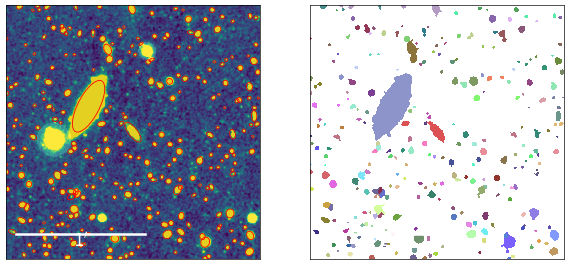

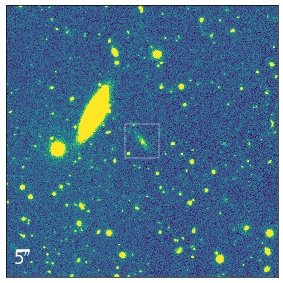

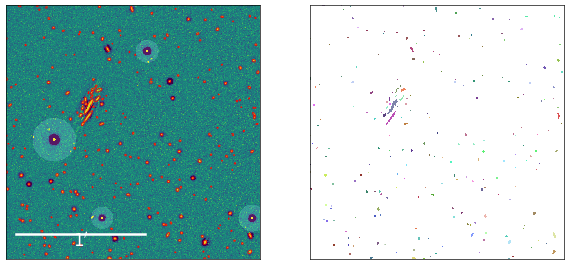

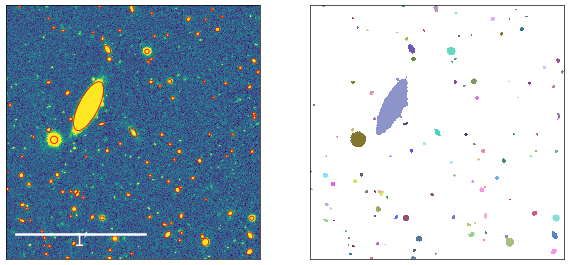

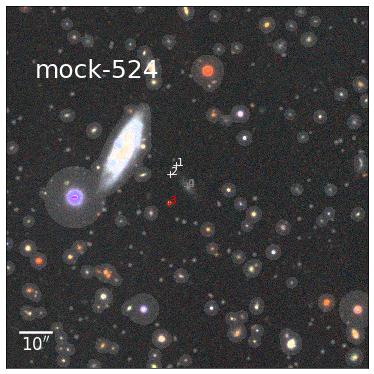

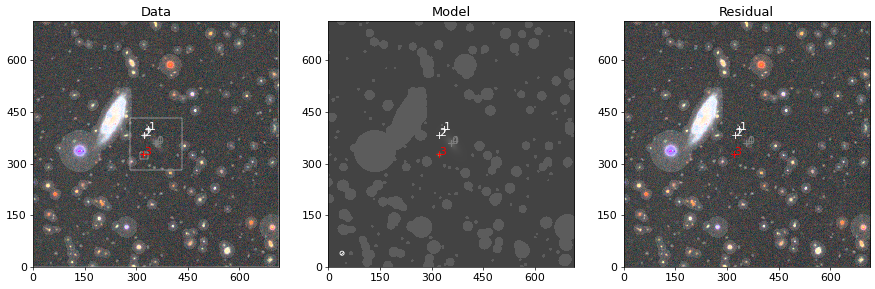

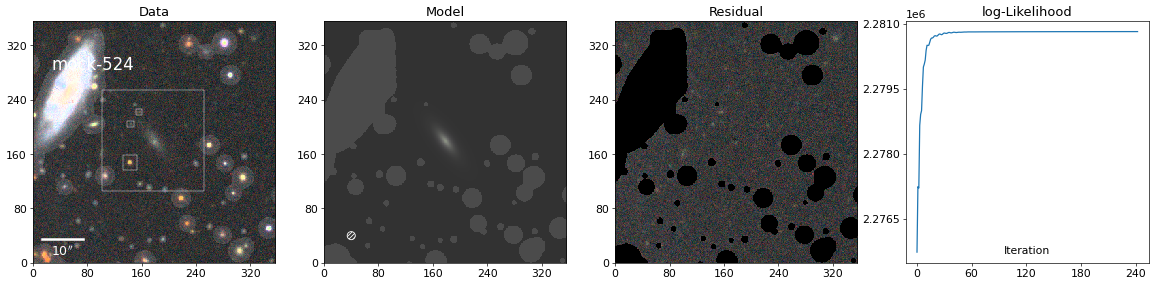

In [13]:
fitter.fit()

#### Step-by-step

In [30]:
fitter._first_gaia_search()

    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    8 stars from Gaia are masked!


In [31]:
# Set the weights of saturated star centers to zero
# In order to make the box size estimation more accurate.
temp = np.copy(fitter.data.masks)
for i in range(len(fitter.data.channels)):
    temp[i][~fitter.msk_star_ori.astype(bool)] = 0
    fitter.data.weights[i][temp[i].astype(bool)] = 0.0

    Detected 287 objects


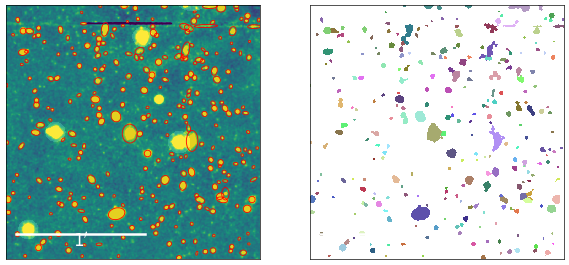

In [32]:
# Replace the vanilla detection with a convolved vanilla detection
first_dblend_cont = 0.07 if max(
    fitter.data.images.shape) * fitter.pixel_scale > 200 else 0.002

if fitter.method == 'wavelet':
    first_dblend_cont = 0.07 if max(
    fitter.data.images.shape) * fitter.pixel_scale > 200 else 0.002
        
fitter._first_detection(first_dblend_cont, conv_radius=2, lvl=4)

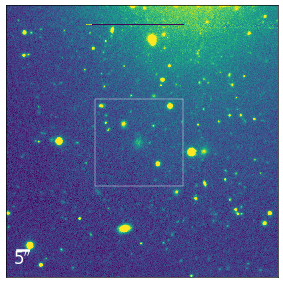

In [33]:
fitter._estimate_box(fitter.cen_obj)

In [34]:
fitter._mask_stars_outside_box()

    7 stars from Gaia are masked!


    Detected 189 objects


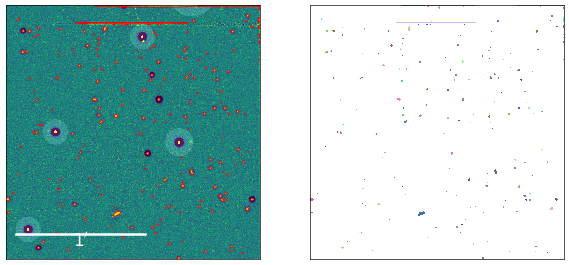

In [35]:
fitter._cpct_obj_detection()

In [36]:
from kuaizi.display import draw_circles

    Detected 98 objects


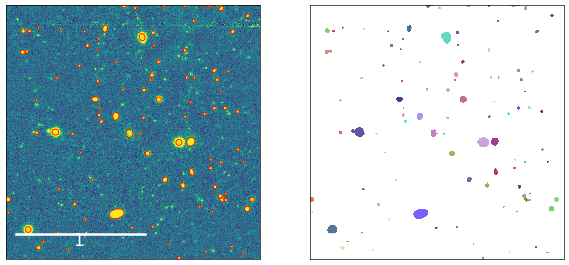

In [37]:
fitter._big_obj_detection()

In [38]:
fitter._merge_catalogs()

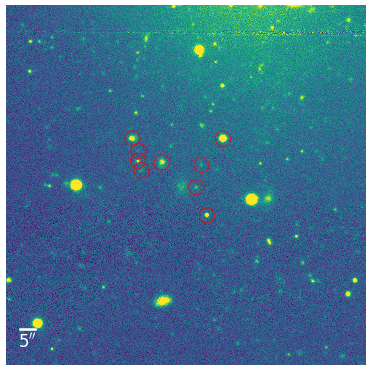

In [39]:
draw_circles(fitter.data.images[0], fitter.obj_cat_big)

In [66]:
fitter._construct_obs_frames()

In [74]:
fitter._add_central_source(min_grad=fitter.min_grad, thresh=0.1)

  - Added Spergel profile with bbox = (4, 572, 572)


In [75]:
fitter.blend = scarlet.Blend(fitter._sources, fitter.observation)

In [60]:
fitter._add_central_source(min_grad=fitter.min_grad, thresh=0.1)
fitter._add_other_sources(min_grad=0.1, thresh=0.1)

    Added constant sky background
    Total number of sources: 11


[<AxesSubplot:title={'center':'Data'}>,
 <AxesSubplot:title={'center':'Model'}>,
 <AxesSubplot:title={'center':'Residual'}>]

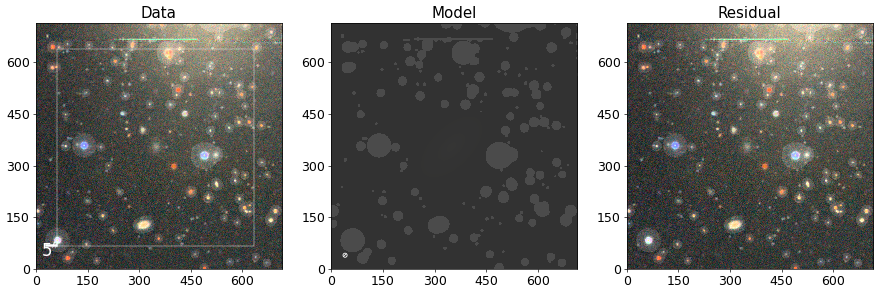

In [76]:
kz.display.display_scarlet_model(
    fitter.blend,
#     show_ind=[0],
    #zoomin_size=50,
    minimum=-0.2,
    stretch=0.9,
    add_boxes=True,
    channels='griz',
    show_mask=False,
    show_mark=False, 
    show_loss=False)

  - Optimizing scarlet model...
    Optimizaiton: Succeed for e_rel = 0.0001 with 84 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0005 with 164 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0002 with 244 iterations! Try higher accuracy!
  - After 212 iterations, logL = 2358520.79


PicklingError: Can't pickle <class 'scarlet.source.SpergelSource'>: it's not the same object as scarlet.source.SpergelSource

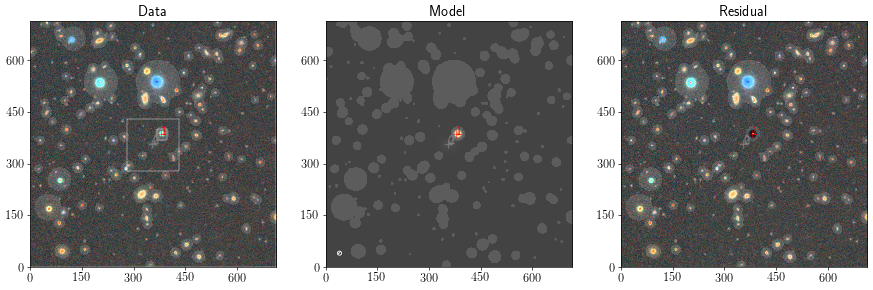

In [159]:
fitter._optimize()

In [160]:
try:
    fitter._find_sed_ind()
    fitter._gen_final_mask()
    fitter._display_results()
except:
    pass

  - Components [0] are considered as the target galaxy.
  - Masking stars and other sources that are modeled, to deal with leaky flux issue.
    1 stars from Gaia are masked!
  - Saving the results as /scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Model/nsa_z001_002/spergel/mock-70832-trained-model-spergel.df


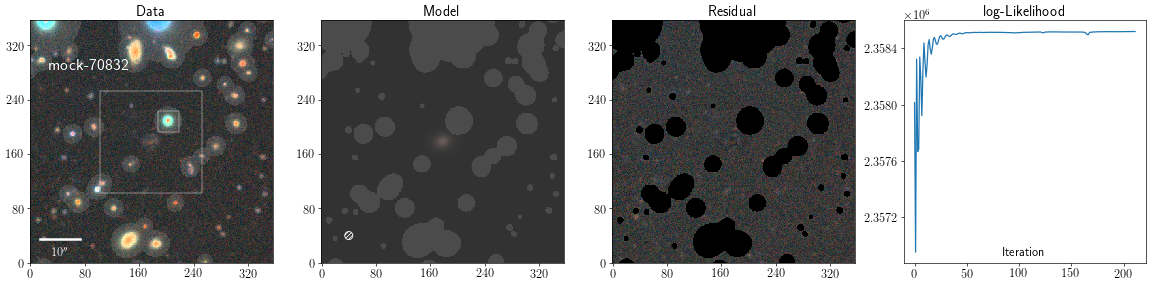

In [161]:
fitter._display_results()

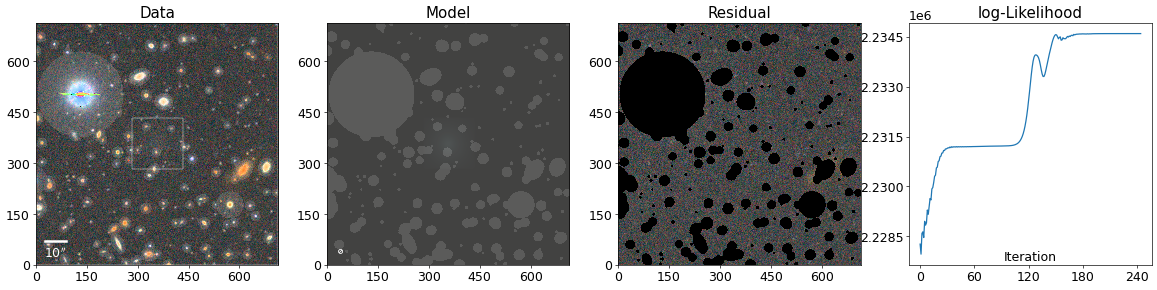

In [239]:
fig = kz.display.display_scarlet_results_tigress(
        fitter._blend,
        fitter.final_mask,
#         show_ind=fitter.sed_ind,
#         zoomin_size=50,
        minimum=-0.2,
        stretch=0.7,
        Q=1,
        channels=fitter.data.channels,
        show_loss=True,
        show_mask=False,
        show_mark=False,
        scale_bar=True)

In [240]:
from kuaizi.measure import cal_cnu
david = fitter.blend.sources[0]
print(david.get_parameter(3) * 0.168)
sed, morph = david.get_models_of_children()
true_flux = (2 * np.pi * david.parameters[3]**2) / cal_cnu(david.parameters[2])**2
print('mag:', -2.5 * np.log10(true_flux * sed) + 27.0)
print('Sky:', -2.5 * np.log10(fitter.blend.sources[-1].get_model().mean(axis=(1, 2)) / 0.168**2) + 27)

[[9.78091718]]
mag: [[20.95255956 20.47541381 20.3080208  20.54341934]]
Sky: [30.39239143 29.73059861 28.67050248 28.82035989]


[<AxesSubplot:title={'center':'Background'}>,
 <AxesSubplot:title={'center':'Mock Image'}>,
 <AxesSubplot:title={'center':'Model'}>]

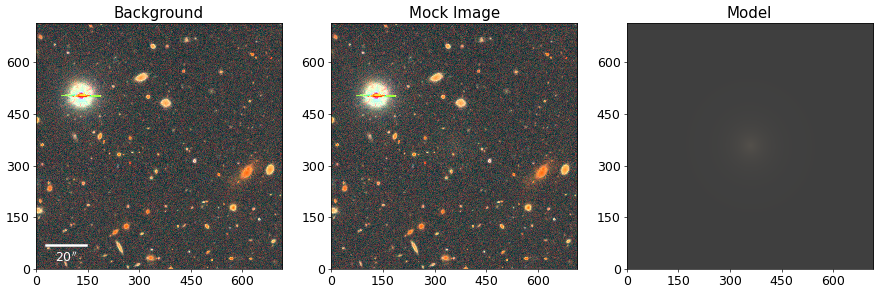

In [241]:
import pickle

with open(f'./Cutout/mock_sample/mock_{lsbg["viz-id"]}.pkl', 'rb') as fp:
    gal = pickle.load(fp)
gal.display(stretch=0.8)

In [244]:
gal.model.info

{'comp': [{'model': galsim.sersic.Sersic,
   'model_params': {'n': 0.9633822325633931,
    'half_light_radius': 12.097237240417355},
   'shear_params': {'q': 0.956260928877007,
    'beta': coord.Angle(-1.2817051303891247, coord.radians)},
   'sed': array([0.5723978 , 0.83970861, 1.        , 1.16199369])}],
 'imag': 19.8831568836033,
 'flux_fraction': [1.0],
 'ra': 346.1801183805011,
 'dec': 0.9159681129547782,
 'gmag': 20.4889119964195,
 'rmag': 20.072835367354816,
 'zmag': 19.720147458149533}

In [100]:
from kuaizi.measure import makeMeasurement, makeMeasurementMockGal

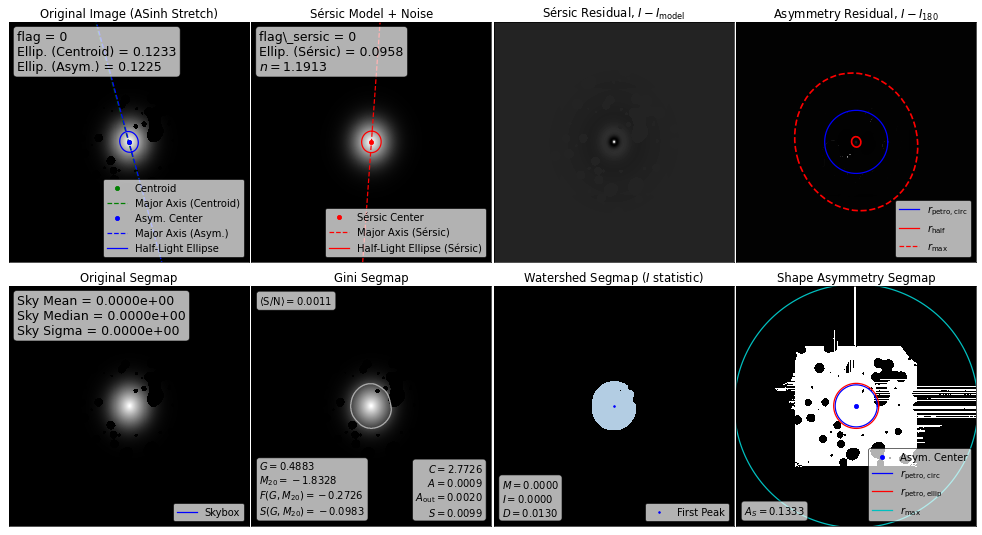

In [101]:
measurement, t = makeMeasurement(list(np.array(fitter.blend.sources)[fitter.sed_ind]),
                                 fitter.blend.observations[0],
                                 aggr_mask=fitter.final_mask.astype(bool),
                                 makesegmap=False, sigma=0.02,
                                 zeropoint=27.0, out_prefix=None,
                                 show_fig=True, asinh_a=0.02, framealpha=0.7)
#row = _write_to_row(row, measurement)

In [102]:
# Sky SB
-2.5 * np.log10(fitter.blend.sources[-1].get_model().mean(axis=(1, 2)) / 0.168**2) + 27

Parameter([29.4934964 , 28.74595229, 28.74534842, 28.11704383])

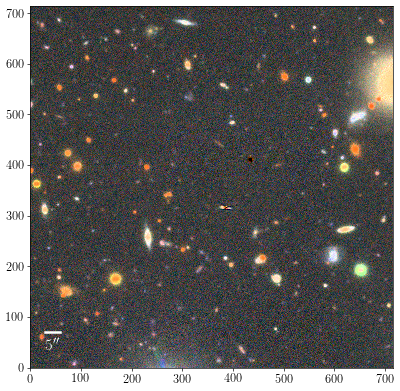

In [142]:
display_rgb(gal.mock.images - fitter.observation.render(fitter.blend.get_model()), stretch=0.8);

In [104]:
print(measurement['rhalf_circularized'] * 0.168)
print(gal.model.info['comp'][0]['model_params']['half_light_radius'])
measurement['sersic_rhalf'] * 0.168 * np.sqrt(1 - measurement['ellipticity_asymmetry'])

4.914961939897793
4.556496604388463


5.068036433903733

In [105]:
measurement['SB_eff_avg'], measurement['mag']

(array([25.790022, 25.45826 , 25.405367, 25.216639], dtype=float32),
 array([20.323706, 19.991943, 19.93905 , 19.75032 ], dtype=float32))

In [106]:
-2.5 * np.log10(measurement['flux_circ']) + 27

array([20.344858, 20.013096, 19.960203, 19.771473], dtype=float32)

In [107]:
gal.model.info['gmag'], gal.model.info['rmag'], gal.model.info['imag']

(20.420431085096865, 20.089120531929915, 19.987150741690147)

In [108]:
measurement['ellipticity_asymmetry'], 1 - gal.model.info['comp'][0]['shear_params']['q']

(0.12251074353348768, 0.1277100516230144)

In [11]:
import dill
from kuaizi.measure import makeMeasurement, makeMeasurementMockGal

In [108]:
lsbg = lsbg_cat[1072] # 12 # 69

[<AxesSubplot:title={'center':'Data'}>,
 <AxesSubplot:title={'center':'Model'}>,
 <AxesSubplot:title={'center':'Residual'}>,
 <AxesSubplot:title={'center':'log-Likelihood'}, xlabel='Iteration'>]

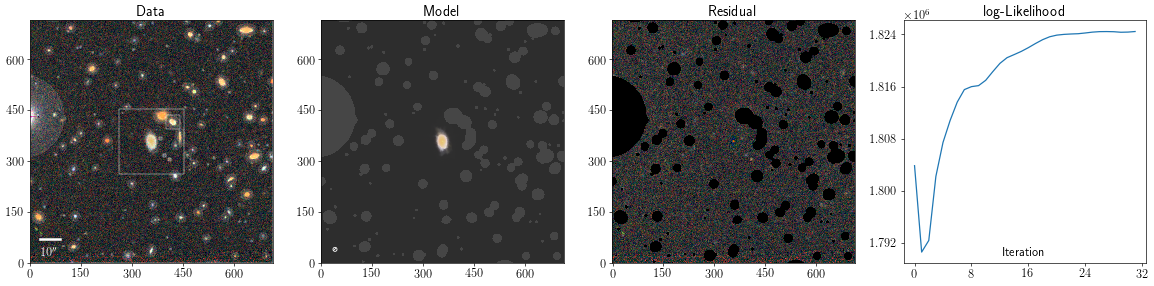

In [110]:
ind = lsbg['viz-id']
method = 'vanilla'
# method = 'vanilla'
with open(f'./Model/nsa_z001_002/{method}/nsa-{ind}-trained-model-{method}.df', "rb") as fp:
    blend, info, mask = dill.load(fp)
    fp.close()
    
kz.display.display_scarlet_results_tigress(
    blend,
    mask,
    show_ind=[0],
    #zoomin_size=50,
    minimum=-0.2,
    stretch=1,
    add_boxes=True,
    channels='griz',
    show_mask=False,
    show_mark=False, 
    show_loss=True)

In [251]:
from kuaizi.measure import cal_cnu
david = blend.sources[0]
print(david.get_parameter(3) * 0.168)
sed, morph = david.get_models_of_children()
true_flux = (2 * np.pi * david.parameters[3]**2) / cal_cnu(david.parameters[2])**2
-2.5 * np.log10(true_flux * sed) + 27.0

[[5.35024453]]


Parameter([[21.09256138, 20.52215181, 20.21650564, 20.24670457]])

[<AxesSubplot:title={'center':'Background'}>,
 <AxesSubplot:title={'center':'Mock Image'}>,
 <AxesSubplot:title={'center':'Model'}>]

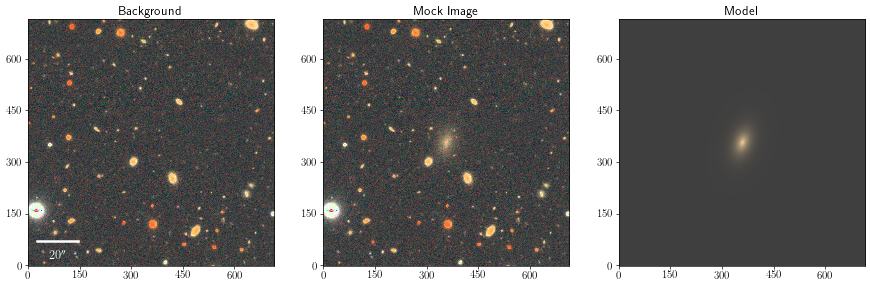

In [16]:
import pickle

with open(f'./Cutout/mock_sample/mock_{ind}.pkl', 'rb') as fp:
    gal = pickle.load(fp)
gal.display(stretch=0.8)

In [17]:
gal.model.info

{'comp': [{'model': galsim.sersic.Sersic,
   'model_params': {'n': 1.028798351313437,
    'half_light_radius': 5.402173888566778},
   'shear_params': {'q': 0.6110458275533068,
    'beta': coord.Angle(1.2569557471007504, coord.radians)},
   'sed': array([0.48227494, 0.78764329, 1.        , 1.14666919])}],
 'imag': 19.235374805524145,
 'flux_fraction': [1.0],
 'ra': 150.23999749502534,
 'dec': 1.6820617760172785,
 'gmag': 20.02713806681768,
 'rmag': 19.494550856382407,
 'zmag': 19.086779447544068}

In [17]:
src = blend.sources[0]

In [18]:
sed, morph = src.get_models_of_children()

In [23]:
from kuaizi.measure import cal_cnu

In [24]:
true_flux = (2 * np.pi * src.parameters[3]
             ** 2) / cal_cnu(src.parameters[2])**2

In [25]:
true_flux

Parameter([[2281.71784862]])

In [ ]:

measure_dict['flux'] = np.array(true_flux * sed).ravel()

In [15]:
measurement['mag'] + 2.5 * np.log10(2 * np.pi * 5.29124731838925**2)

array([25.68790056, 25.17335591, 24.890307  , 24.7395501 ])

In [13]:
measurement

{'flux': array([ 589.02776564,  946.13613239, 1227.9288129 , 1410.83411416]),
 'mag': array([20.07466058, 19.56011593, 19.27706702, 19.12631012]),
 'xc_centroid': 357.1417046352392,
 'yc_centroid': 357.2510046552573,
 'xc_peak': 357,
 'yc_peak': 357,
 'ellipticity_centroid': 0.3166487822744145,
 'elongation_centroid': 1.4633763342492085,
 'orientation_centroid': 1.2173937606813743,
 'xc_asymmetry': 357.09274031872377,
 'yc_asymmetry': 357.1181498081936,
 'ellipticity_asymmetry': 0.3166544769087113,
 'elongation_asymmetry': 1.4633885292410251,
 'orientation_asymmetry': 1.217393769881961,
 'rpetro_circ': 69.94761766006506,
 'rpetro_ellip': 82.34551445847171,
 'rhalf_circ': 31.04244076068336,
 'rhalf_ellip': 36.70931702963555,
 'rhalf_circularized': 30.34565257827869,
 'rhalf_spergel': 31.495519752316966,
 'r20': 15.32360043870817,
 'r50': 30.949788953565008,
 'r80': 54.08800357963841,
 'SB_0_circ': array([24.73551487, 24.22097022, 23.93792131, 23.78716441]),
 'SB_0_ellip': array([24.7355

In [118]:
img, bkg = makeMeasurement(list(np.array(blend.sources)[info['sed_ind']]),
                                 blend.observations[0],
                                 aggr_mask=mask.astype(bool),
                                 method='vanilla',
                                 makesegmap=True, sigma=0.02,
                                 zeropoint=27.0, out_prefix=None,
                                 show_fig=True, asinh_a=0.02, framealpha=0.7)

In [119]:
import sep

In [124]:
_, segmap = sep.extract(img - bkg.globalback, 0.05, err=bkg.globalrms, minarea=1,
                                deblend_cont=.1,
                                mask=None, segmentation_map=True)

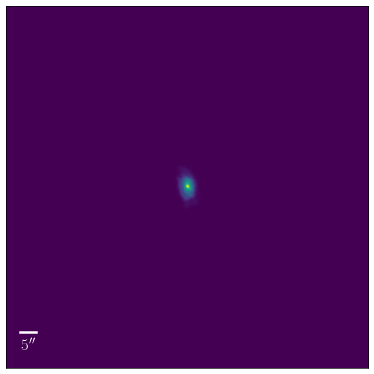

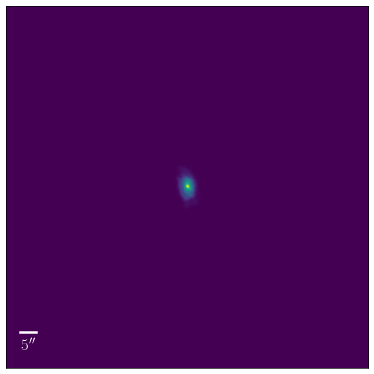

In [116]:
display_single(img, scale='linear')

In [113]:
measurement, t = makeMeasurement(list(np.array(blend.sources)[info['sed_ind']]),
                                 blend.observations[0],
                                 aggr_mask=mask.astype(bool),
                                 method='vanilla',
                                 makesegmap=True, sigma=0.02,
                                 zeropoint=27.0, out_prefix=None,
                                 show_fig=True, asinh_a=0.02, framealpha=0.7)

Exception: internal pixel buffer full: The limit of 300000 active object pixels over the detection threshold was reached. Check that the image is background subtracted and the detection threshold is not too low. If you need to increase the limit, use set_extract_pixstack.